In [13]:
import json
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Dict, List, Tuple, Optional
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from annoy import AnnoyIndex
import pickle
import warnings

# Import visualization utilities
from utils.visualization import (
    plot_confusion_matrix, 
    plot_confidence_distribution,
    plot_similarity_vs_confidence,
    plot_threshold_analysis,
    print_evaluation_summary,
    print_service_predictions_summary,
    create_results_dashboard,
    save_visualization_summary
)

warnings.filterwarnings('ignore')

In [ ]:
class AWSLabelPropagator:
    def __init__(self, embeddings_dir: Path, labels_file: Path, embedding_format: str = "with_service_params"):
        """
        Initialize the label propagator.
        
        Args:
            embeddings_dir: Path to directory containing embedding files
            labels_file: Path to CSV file with manual labels
            embedding_format: Which embedding format to use for propagation
        """
        self.embeddings_dir = embeddings_dir
        self.labels_file = labels_file
        self.embedding_format = embedding_format
        
        # Load manual labels
        self.manual_labels = self._load_manual_labels()
        
        # Storage for embeddings and labels
        self.method_embeddings = {}
        self.method_labels = {}
        self.service_methods = defaultdict(list)
        
        # Annoy-specific storage
        self.annoy_indexes = {}
        self.method_lookups = {}
        self.embedding_dim = None  # Will be auto-detected from first embedding
        
        print(f"🏷️ Loaded {len(self.manual_labels)} manual labels")
        print(f"📊 Using embedding format: {embedding_format}")
    
    def set_embedding_dimension(self, dimension: int) -> None:
        """
        Set the embedding dimension manually.
        
        Args:
            dimension: The embedding dimension to use
        """
        self.embedding_dim = dimension
        print(f"🔧 Embedding dimension set to: {dimension}")
    
    def _validate_embedding_dimension(self) -> None:
        """Validate that embedding dimension is set."""
        if self.embedding_dim is None:
            raise ValueError("Embedding dimension not set. Call set_embedding_dimension() or load embeddings first.")
    
    def _load_manual_labels(self) -> Dict[Tuple[str, str], str]:
        """Load manual labels from CSV file."""
        df = pd.read_csv(self.labels_file, sep=';')
        labels = {}
        
        current_service = None
        for _, row in df.iterrows():
            service = row['API Service'].strip() if pd.notna(row['API Service']) and row['API Service'].strip() else current_service
            if service and service != current_service:
                current_service = service
            
            method = row['Methods'].strip() if pd.notna(row['Methods']) else None
            label = row['Sink/Source'].strip() if pd.notna(row['Sink/Source']) else None
            
            if method and label and current_service:
                # Normalize labels
                if label.lower() in ['source', 'source / x']:
                    normalized_label = 'source'
                elif label.lower() in ['sink']:
                    normalized_label = 'sink'
                else:
                    normalized_label = 'none'
                
                labels[(current_service.lower(), method)] = normalized_label
        
        return labels
    
    def load_method_embeddings(self, services: List[str] = None) -> None:
        """Load method embeddings for specified services."""
        methods_dir = self.embeddings_dir / "methods"
        
        if services is None:
            services = [d.name for d in methods_dir.iterdir() if d.is_dir()]
        
        print(f"📂 Loading embeddings for services: {services}")
        
        for service in services:
            service_dir = methods_dir / service
            if not service_dir.exists():
                print(f"⚠️ Service directory not found: {service}")
                continue
            
            method_files = list(service_dir.glob("*.json"))
            print(f"📁 {service}: {len(method_files)} methods")
            
            for method_file in method_files:
                with open(method_file, 'r') as f:
                    method_data = json.load(f)
                    
                    service_name = method_data['service_name'].lower()
                    method_name = method_data['method_name']
                    
                    if self.embedding_format in method_data.get('embeddings', {}):
                        embedding = np.array(method_data['embeddings'][self.embedding_format])
                        
                        # Auto-detect embedding dimension from first embedding
                        if self.embedding_dim is None:
                            self.embedding_dim = len(embedding)
                            print(f"🔍 Auto-detected embedding dimension: {self.embedding_dim}")
                        
                        # Validate dimension consistency
                        if len(embedding) != self.embedding_dim:
                            print(f"⚠️ Warning: Embedding dimension mismatch for {service_name}.{method_name}: "
                                  f"expected {self.embedding_dim}, got {len(embedding)}")
                            continue
                        
                        key = (service_name, method_name)
                        
                        self.method_embeddings[key] = embedding
                        self.service_methods[service_name].append(method_name)
                        
                        # Add label if we have it manually labeled
                        if key in self.manual_labels:
                            self.method_labels[key] = self.manual_labels[key]
        
        print(f"✅ Loaded {len(self.method_embeddings)} method embeddings")
        print(f"🏷️ Found {len(self.method_labels)} labeled methods")
        if self.embedding_dim:
            print(f"📐 Embedding dimension: {self.embedding_dim}")
        else:
            print("⚠️ No embeddings loaded - dimension not detected")
    
    def _build_service_index(self, service: str) -> None:
        """Build Annoy index for a specific service."""
        self._validate_embedding_dimension()
        
        service = service.lower()
        service_methods = [(service, method) for method in self.service_methods[service]]
        
        # Create Annoy index
        index = AnnoyIndex(self.embedding_dim, 'angular')  # angular = cosine distance
        method_lookup = {}
        
        # Add embeddings to index
        idx = 0
        for method_key in service_methods:
            if method_key in self.method_embeddings:
                index.add_item(idx, self.method_embeddings[method_key])
                method_lookup[idx] = method_key
                idx += 1
        
        # Build index with 10 trees (good balance of speed/accuracy)
        index.build(10)
        
        # Store index and lookup
        self.annoy_indexes[service] = index
        self.method_lookups[service] = method_lookup
        
        print(f"   🔧 Built Annoy index for {service}: {len(method_lookup)} methods")
    
    def _ensure_service_index(self, service: str) -> None:
        """Ensure Annoy index exists for a service."""
        service = service.lower()
        if service not in self.annoy_indexes:
            self._build_service_index(service)
    
    def _get_neighbors_with_similarities(self, service: str, query_embedding: np.ndarray, k: int) -> List[Tuple[Tuple[str, str], float]]:
        """Get k nearest neighbors with cosine similarities."""
        self._ensure_service_index(service)
        
        index = self.annoy_indexes[service]
        method_lookup = self.method_lookups[service]
        
        # Get more neighbors than needed since we'll filter
        search_k = min(k * 3, len(method_lookup))
        neighbor_indices = index.get_nns_by_vector(query_embedding, search_k)
        
        # Calculate actual cosine similarities
        neighbors_with_sims = []
        for idx in neighbor_indices:
            if idx in method_lookup:
                neighbor_key = method_lookup[idx]
                neighbor_embedding = self.method_embeddings[neighbor_key]
                
                # Calculate cosine similarity (convert from distance)
                similarity = cosine_similarity([query_embedding], [neighbor_embedding])[0][0]
                neighbors_with_sims.append((neighbor_key, similarity))
        
        # Sort by similarity and return top k
        neighbors_with_sims.sort(key=lambda x: x[1], reverse=True)
        return neighbors_with_sims[:k]
    
    def propagate_within_service(self, service: str, k: int = 5, threshold: float = 0.7, 
                               max_iterations: int = 10, min_confidence: float = 0.5, min_threshold: float = 0.1) -> Dict[str, str]:
        """
        Iteratively propagate labels within a single service using Annoy for fast similarity search.
        
        Args:
            service: Service name to propagate within
            k: Number of neighbors for k-NN
            threshold: Minimum similarity threshold for high-confidence propagation
            max_iterations: Maximum number of iterations to perform
            min_confidence: Minimum confidence for accepting predictions in later iterations
            
        Returns:
            Dictionary of method -> predicted label
        """
        service = service.lower()
        predictions = {}
        
        # Get labeled and unlabeled methods for this service
        labeled_methods = [(svc, method) for (svc, method) in self.method_labels.keys() if svc == service]
        all_methods = [(service, method) for method in self.service_methods[service]]
        unlabeled_methods = [m for m in all_methods if m not in self.method_labels]
        
        if len(labeled_methods) == 0:
            print(f"⚠️ No labeled methods found for service: {service}")
            return predictions
        
        print(f"🔄 Propagating in {service}: {len(labeled_methods)} labeled → {len(unlabeled_methods)} unlabeled")
        
        # Ensure we have an index for this service
        self._ensure_service_index(service)
        
        # Create a copy of method_labels to track temporary labels during iteration
        temp_method_labels = self.method_labels.copy()
        remaining_unlabeled = set(unlabeled_methods)
        
        # Initialize threshold - will be lowered across iterations if needed
        current_threshold = threshold
        
        for iteration in range(max_iterations):
            if not remaining_unlabeled:
                break
                
            iteration_predictions = {}
            
            # For first iteration, use the original threshold
            # For later iterations, use min_confidence unless we've lowered it further
            if iteration > 0:
                current_threshold = min(current_threshold, min_confidence)
            
            print(f"🔄 Iteration {iteration + 1}: {len(remaining_unlabeled)} remaining unlabeled (threshold: {current_threshold:.1f})")
            
            # Predict for remaining unlabeled methods
            for method_key in list(remaining_unlabeled):
                if method_key in self.method_embeddings:
                    embedding = self.method_embeddings[method_key]
                    
                    # Get neighbors with similarities using Annoy
                    neighbors_with_sims = self._get_neighbors_with_similarities(service, embedding, k)
                    
                    # Filter by labeled neighbors (including temporary labels)
                    labeled_neighbors = []
                    for neighbor_key, similarity in neighbors_with_sims:
                        if neighbor_key in temp_method_labels:
                            labeled_neighbors.append((neighbor_key, similarity))
                    
                    if labeled_neighbors:
                        # Filter by threshold for high-confidence predictions
                        valid_neighbors = [(nk, sim) for nk, sim in labeled_neighbors if sim >= current_threshold]
                        
                        if valid_neighbors:
                            # High-confidence prediction using threshold
                            label_weights = defaultdict(float)
                            label_counts = defaultdict(int)
                            for neighbor_key, similarity in valid_neighbors:
                                label = temp_method_labels[neighbor_key]
                                label_weights[label] += similarity
                                label_counts[label] += 1
                            
                            predicted_label = max(label_weights, key=label_weights.get)
                            total_neighbors = len(valid_neighbors)
                            confidence = label_counts[predicted_label] / total_neighbors
                            max_similarity = max(sim for _, sim in valid_neighbors)
                            
                            # Only accept if confidence meets minimum threshold
                            if confidence >= min_confidence:
                                iteration_predictions[method_key[1]] = {
                                    'label': predicted_label,
                                    'confidence': confidence,
                                    'similarity': max_similarity,
                                    'neighbors': [neighbor_key for neighbor_key, _ in valid_neighbors],
                                    'iteration': iteration + 1
                                }
                        elif iteration == max_iterations - 1:
                            # Final iteration: use all labeled neighbors regardless of threshold
                            label_weights = defaultdict(float)
                            label_counts = defaultdict(int)
                            for neighbor_key, similarity in labeled_neighbors:
                                label = temp_method_labels[neighbor_key]
                                label_weights[label] += similarity
                                label_counts[label] += 1
                            
                            predicted_label = max(label_weights, key=label_weights.get)
                            total_neighbors = len(labeled_neighbors)
                            confidence = label_counts[predicted_label] / total_neighbors
                            max_similarity = max(sim for _, sim in labeled_neighbors)
                            
                            iteration_predictions[method_key[1]] = {
                                'label': predicted_label,
                                'confidence': confidence,
                                'similarity': max_similarity,
                                'neighbors': [neighbor_key for neighbor_key, _ in labeled_neighbors],
                                'iteration': iteration + 1
                            }
            
            # Add new predictions to results and temporary labels
            if iteration_predictions:
                predictions.update(iteration_predictions)
                print(f"✅ Added {len(iteration_predictions)} new predictions")
                
                # Update temporary labels for next iteration
                for method_name, pred_data in iteration_predictions.items():
                    method_key = (service, method_name)
                    temp_method_labels[method_key] = pred_data['label']
                    remaining_unlabeled.discard(method_key)
            else:
                print(f"⚠️ No new predictions in iteration {iteration + 1}")
                # Lower threshold for next iteration if no predictions made
                if iteration < max_iterations - 1:
                    current_threshold = max(min_threshold, current_threshold - 0.1)
                    if current_threshold == min_threshold:
                        print("⚠️ Minimum threshold reached, stopping further iterations")
                        break
                    print(f"📉 Lowering threshold to {current_threshold:.1f}")

        
        if remaining_unlabeled:
            if iteration == max_iterations:
                print("⚠️ Maximum number of iterations reached")
            print(f"⚠️ {len(remaining_unlabeled)} methods remain unlabeled after {iteration+1} iterations")
        else:
            print(f"🎉 All methods labeled after {iteration} iterations!")

        return predictions

    def propagate_all_services(self, k: int = 5, threshold: float = 0.7, max_iterations: int = 5, min_confidence: float = 0.5, min_threshold: float = 0.1) -> Dict[str, Dict[str, str]]:
        """Propagate labels for all loaded services."""
        all_predictions = {}
        
        for service in self.service_methods.keys():
            predictions = self.propagate_within_service(service, k, threshold, max_iterations, min_confidence, min_threshold)
            if predictions:
                all_predictions[service] = predictions
                print(f"✅ {service}: {len(predictions)} predictions")
        
        return all_predictions
    
    def propagate_cross_service(self, source_service: str, target_service: str, 
                               k: int = 5, threshold: float = 0.6) -> Dict[str, str]:
        """
        Propagate labels from one service to another using Annoy.
        
        Args:
            source_service: Service with labeled methods to use as training
            target_service: Service to predict labels for
            k: Number of neighbors for k-NN
            threshold: Minimum similarity threshold for propagation
            
        Returns:
            Dictionary of method -> predicted label for target service
        """
        source_service = source_service.lower()
        target_service = target_service.lower()
        predictions = {}
        
        # Get labeled methods from source service
        source_labeled = [(svc, method) for (svc, method) in self.method_labels.keys() if svc == source_service]
        
        # Get all methods from target service
        target_methods = [(target_service, method) for method in self.service_methods[target_service]]
        
        if len(source_labeled) == 0:
            print(f"⚠️  No labeled methods found for source service: {source_service}")
            return predictions
        
        print(f"🔀 Cross-service propagation: {source_service} ({len(source_labeled)} labeled) → {target_service} ({len(target_methods)} methods)")
        
        # Create a temporary combined index for cross-service search
        combined_index = AnnoyIndex(self.embedding_dim, 'angular')
        source_lookup = {}
        
        # Add source service embeddings to index
        idx = 0
        for method_key in source_labeled:
            if method_key in self.method_embeddings:
                combined_index.add_item(idx, self.method_embeddings[method_key])
                source_lookup[idx] = method_key
                idx += 1
        
        combined_index.build(10)
        
        # Predict for target service methods
        for method_key in target_methods:
            if method_key in self.method_embeddings and method_key not in self.method_labels:
                embedding = self.method_embeddings[method_key]
                
                # Get neighbors from source service
                neighbor_indices = combined_index.get_nns_by_vector(embedding, k)
                
                # Calculate similarities for all neighbors
                all_neighbors = []
                for idx in neighbor_indices:
                    if idx in source_lookup:
                        neighbor_key = source_lookup[idx]
                        neighbor_embedding = self.method_embeddings[neighbor_key]
                        similarity = cosine_similarity([embedding], [neighbor_embedding])[0][0]
                        all_neighbors.append((neighbor_key, similarity))
                
                if all_neighbors:
                    # Filter by threshold for high-confidence predictions
                    valid_neighbors = [(nk, sim) for nk, sim in all_neighbors if sim >= threshold]
                    
                    if valid_neighbors:
                        # High-confidence prediction using threshold
                        label_weights = defaultdict(float)
                        label_counts = defaultdict(int)
                        for neighbor_key, similarity in valid_neighbors:
                            label = self.method_labels[neighbor_key]
                            label_weights[label] += similarity
                            label_counts[label] += 1
                        
                        predicted_label = max(label_weights, key=label_weights.get)
                        total_neighbors = len(valid_neighbors)
                        confidence = label_counts[predicted_label] / total_neighbors
                        max_similarity = max(sim for _, sim in valid_neighbors)
                        
                        predictions[method_key[1]] = {
                            'label': predicted_label,
                            'confidence': confidence,
                            'similarity': max_similarity,
                            'source_neighbors': [neighbor_key for neighbor_key, _ in valid_neighbors]
                        }
                    else:
                        # No neighbors meet threshold, use all neighbors (like sklearn)
                        label_weights = defaultdict(float)
                        label_counts = defaultdict(int)
                        for neighbor_key, similarity in all_neighbors:
                            label = self.method_labels[neighbor_key]
                            label_weights[label] += similarity
                            label_counts[label] += 1
                        
                        predicted_label = max(label_weights, key=label_weights.get)
                        total_neighbors = len(all_neighbors)
                        confidence = label_counts[predicted_label] / total_neighbors
                        max_similarity = max(sim for _, sim in all_neighbors)
                        
                        predictions[method_key[1]] = {
                            'label': predicted_label,
                            'confidence': confidence,
                            'similarity': max_similarity,
                            'source_neighbors': [neighbor_key for neighbor_key, _ in all_neighbors]
                        }
        
        return predictions
    
    def evaluate_propagation(self, test_size: float = 0.3, k: int = 5) -> Dict[str, float]:
        """
        Evaluate label propagation using train/test split of manually labeled data.
        Note: Uses sklearn for evaluation to maintain compatibility with existing metrics.
        """
        if len(self.method_labels) < 10:
            print("⚠️ Not enough labeled data for evaluation")
            return {}
        
        # Prepare data
        methods = list(self.method_labels.keys())
        X = np.array([self.method_embeddings[method] for method in methods])
        y = [self.method_labels[method] for method in methods]
        
        # Split data
        X_train, X_test, y_train, y_test, methods_train, methods_test = train_test_split(
            X, y, methods, test_size=test_size, random_state=42, stratify=y
        )
        
        # For evaluation, create a temporary Annoy index with training data
        eval_index = AnnoyIndex(self.embedding_dim, 'angular')
        train_lookup = {}
        
        for idx, (embedding, label) in enumerate(zip(X_train, y_train)):
            eval_index.add_item(idx, embedding)
            train_lookup[idx] = label
        
        eval_index.build(10)
        
        # Predict using Annoy
        y_pred = []
        for test_embedding in X_test:
            neighbor_indices = eval_index.get_nns_by_vector(test_embedding, k)
            
            # Vote based on neighbors
            label_votes = defaultdict(int)
            for idx in neighbor_indices:
                if idx in train_lookup:
                    label_votes[train_lookup[idx]] += 1
            
            if label_votes:
                predicted_label = max(label_votes, key=label_votes.get)
                y_pred.append(predicted_label)
            else:
                y_pred.append('none')  # Default prediction
        
        # Calculate metrics
        report = classification_report(y_test, y_pred, output_dict=True)
        
        print("🎯 Evaluation Results:")
        print(classification_report(y_test, y_pred))
        
        # Use visualization utility for confusion matrix
        plot_confusion_matrix(y_test, y_pred, 'Label Propagation - Confusion Matrix (Annoy)')
        
        return report
    
    def find_optimal_k(self, k_values: List[int] = [3, 5, 7, 10]) -> int:
        """Find optimal k value using cross-validation with Annoy."""
        if len(self.method_labels) < 10:
            print("⚠️ Not enough labeled data for k optimization")
            return 5
        
        methods = list(self.method_labels.keys())
        X = np.array([self.method_embeddings[method] for method in methods])
        y = [self.method_labels[method] for method in methods]
        
        best_k = 5
        best_score = 0
        
        print("🔍 Finding optimal k value:")
        for k in k_values:
            if k < len(set(y)):  # Ensure k is less than number of classes
                # Use sklearn for cross-validation (simpler for this evaluation)
                knn = KNeighborsClassifier(n_neighbors=min(k, len(X)-1), metric='cosine')
                scores = cross_val_score(knn, X, y, cv=min(5, len(X)//2), scoring='f1_macro')
                avg_score = scores.mean()
                print(f"  k={k}: F1-score = {avg_score:.3f} ± {scores.std():.3f}")
                
                if avg_score > best_score:
                    best_score = avg_score
                    best_k = k
        
        print(f"✅ Best k value: {best_k} (F1-score: {best_score:.3f})")
        return best_k
    
    def analyze_label_distribution(self) -> None:
        """Analyze the distribution of labels across services."""
        service_label_counts = defaultdict(lambda: defaultdict(int))
        
        for (service, method), label in self.method_labels.items():
            service_label_counts[service][label] += 1
        
        print("📊 Label Distribution by Service:")
        print("-" * 50)
        
        for service, label_counts in service_label_counts.items():
            total = sum(label_counts.values())
            print(f"{service.upper()}:")
            for label, count in label_counts.items():
                percentage = (count / total) * 100
                print(f"  {label}: {count} ({percentage:.1f}%)")
            print()
    
    def analyze_method_coverage(self) -> None:
        """Analyze method coverage across services."""
        print("📈 Method Coverage Analysis:")
        print("-" * 50)
        
        for service, methods in self.service_methods.items():
            labeled_count = len([m for m in methods if (service, m) in self.method_labels])
            total_count = len(methods)
            unlabeled_count = total_count - labeled_count
            coverage = (labeled_count / total_count) * 100 if total_count > 0 else 0
            
            print(f"{service.upper()}:")
            print(f"📊 {labeled_count}/{total_count} labeled ({coverage:.1f}% coverage)")
            print(f"🔍 {unlabeled_count} methods need propagation")
        print()
    
    def get_similar_services(self) -> Dict[str, List[str]]:
        """Get suggested similar services for cross-service propagation."""
        similar_services = {
            's3': ['efs', 'fsx', 'backup'],  # Storage services
            'dynamodb': ['rds', 'elasticache', 'neptune', 'documentdb'],  # Database services  
            'lambda': ['ecs', 'batch', 'stepfunctions'],  # Compute services
            'sqs': ['sns', 'eventbridge', 'kinesis', 'mq'],  # Messaging services
            'iam': ['sts', 'ssm', 'cloudwatch'],  # Management services
            'ec2': ['autoscaling', 'elb', 'ecs'],  # Infrastructure services
            'sns': ['sqs', 'eventbridge', 'pinpoint'],  # Messaging services
            'ssm': ['iam', 'cloudwatch', 'config']  # Management services
        }
        
        return similar_services
    
    def save_predictions(self, predictions: Dict[str, Dict[str, str]], 
                        output_file: Path, metadata: Dict = None) -> None:
        """Save predictions to JSON file."""
        # Convert to serializable format
        serializable_predictions = {}
        for service, service_predictions in predictions.items():
            serializable_predictions[service] = {}
            for method, pred_data in service_predictions.items():
                if isinstance(pred_data, dict):
                    # Convert numpy types to native Python types
                    serializable_pred = {}
                    for key, value in pred_data.items():
                        if isinstance(value, np.floating):
                            serializable_pred[key] = float(value)
                        elif isinstance(value, list):
                            serializable_pred[key] = [str(item) for item in value]
                        else:
                            serializable_pred[key] = value
                    serializable_predictions[service][method] = serializable_pred
                else:
                    serializable_predictions[service][method] = pred_data
        
        # Add metadata if provided
        if metadata:
            output_data = {
                'metadata': metadata,
                'predictions': serializable_predictions
            }
        else:
            output_data = serializable_predictions
        
        with open(output_file, 'w') as f:
            json.dump(output_data, f, indent=2)
        
        print(f"💾 Predictions saved to: {output_file}")
    
    def save_indexes(self, index_dir: Path) -> None:
        """Save Annoy indexes for fast loading."""
        index_dir.mkdir(exist_ok=True)
        
        for service, index in self.annoy_indexes.items():
            # Save Annoy index
            index_path = index_dir / f"{service}_index.ann"
            index.save(str(index_path))
            
            # Save lookup table
            lookup_path = index_dir / f"{service}_lookup.pkl"
            with open(lookup_path, 'wb') as f:
                pickle.dump(self.method_lookups[service], f)
        
        print(f"💾 Annoy indexes saved to: {index_dir}")
    
    def load_indexes(self, index_dir: Path) -> None:
        """Load pre-built Annoy indexes."""
        if not index_dir.exists():
            print(f"⚠️ Index directory not found: {index_dir}")
            return
            
        for service in self.service_methods.keys():
            index_path = index_dir / f"{service}_index.ann"
            lookup_path = index_dir / f"{service}_lookup.pkl"
            
            if index_path.exists() and lookup_path.exists():
                # Load Annoy index
                index = AnnoyIndex(self.embedding_dim, 'angular')
                index.load(str(index_path))
                
                # Load lookup table
                with open(lookup_path, 'rb') as f:
                    lookup = pickle.load(f)
                
                self.annoy_indexes[service] = index
                self.method_lookups[service] = lookup
                
                print(f"📂 Loaded Annoy index for {service}: {len(lookup)} methods")

In [15]:
print("🚀 AWS API Label Propagation")
print("=" * 50)

# Configuration - Paths relative to the notebook location
project_root = Path("..")
embeddings_dir = project_root / "embeddings"
labels_file = project_root / "labels.csv"

# Services with manual labels
labeled_services = ['S3', 'DynamoDB', 'Lambda', 'EC2', 'IAM', 'SSM', 'SQS', 'SNS']

print(f"📁 Embeddings directory: {embeddings_dir}")
print(f"🏷️ Labels file: {labels_file}")
print(f"📊 Labeled services: {', '.join(labeled_services)}")

# Verify paths exist
if not embeddings_dir.exists():
    print(f"⚠️ Warning: Embeddings directory not found at {embeddings_dir}")
    print(f"Current working directory: {Path.cwd()}")
    print(f"Looking for: {embeddings_dir.absolute()}")
    
if not labels_file.exists():
    print(f"⚠️ Warning: Labels file not found at {labels_file}")
    print(f"Current working directory: {Path.cwd()}")
    print(f"Looking for: {labels_file.absolute()}")

if embeddings_dir.exists() and labels_file.exists():
    print("✅ All required files and directories found!")

🚀 AWS API Label Propagation
📁 Embeddings directory: ../embeddings
🏷️ Labels file: ../labels.csv
📊 Labeled services: S3, DynamoDB, Lambda, EC2, IAM, SSM, SQS, SNS
✅ All required files and directories found!


In [16]:
print("\n" + "="*50)
print("STEP 1: Loading Data")
print("="*50)

propagator = AWSLabelPropagator(embeddings_dir, labels_file, embedding_format="with_service_params")

# Set embedding dimension for Qwen3-0.6B default
propagator.set_embedding_dimension(1024)

# Load embeddings
propagator.load_method_embeddings(labeled_services)

# Handle Annoy indexes
annoy_indexes_dir = embeddings_dir / "annoy_indexes"

# Try to load existing indexes if they exist
if annoy_indexes_dir.exists():
    print(f"📂 Loading existing Annoy indexes from {annoy_indexes_dir}")
    propagator.load_indexes(annoy_indexes_dir)
else:
    print(f"📁 Creating new Annoy indexes directory: {annoy_indexes_dir}")
    annoy_indexes_dir.mkdir(exist_ok=True)


STEP 1: Loading Data
🏷️ Loaded 85 manual labels
📊 Using embedding format: with_service_params
🔧 Embedding dimension set to: 1024
📂 Loading embeddings for services: ['S3', 'DynamoDB', 'Lambda', 'EC2', 'IAM', 'SSM', 'SQS', 'SNS']
📁 S3: 113 methods
📁 DynamoDB: 61 methods
📁 Lambda: 72 methods
📁 EC2: 661 methods
📁 IAM: 168 methods
📁 SSM: 148 methods
📁 SQS: 27 methods
📁 SNS: 46 methods
✅ Loaded 1296 method embeddings
🏷️ Found 85 labeled methods
📐 Embedding dimension: 1024
📂 Loading existing Annoy indexes from ../embeddings/annoy_indexes
📂 Loaded Annoy index for s3: 113 methods
📂 Loaded Annoy index for dynamodb: 61 methods
📂 Loaded Annoy index for lambda: 72 methods
📂 Loaded Annoy index for ec2: 661 methods
📂 Loaded Annoy index for iam: 168 methods
📂 Loaded Annoy index for ssm: 148 methods
📂 Loaded Annoy index for sqs: 27 methods
📂 Loaded Annoy index for sns: 46 methods


In [17]:
print("\n" + "="*50)
print("STEP 2: Data Analysis")
print("="*50)

propagator.analyze_label_distribution()
propagator.analyze_method_coverage()


STEP 2: Data Analysis
📊 Label Distribution by Service:
--------------------------------------------------
S3:
  none: 2 (20.0%)
  sink: 4 (40.0%)
  source: 4 (40.0%)

DYNAMODB:
  source: 5 (45.5%)
  sink: 3 (27.3%)
  none: 3 (27.3%)

LAMBDA:
  source: 4 (33.3%)
  sink: 6 (50.0%)
  none: 2 (16.7%)

EC2:
  sink: 7 (70.0%)
  none: 2 (20.0%)
  source: 1 (10.0%)

IAM:
  source: 2 (18.2%)
  sink: 8 (72.7%)
  none: 1 (9.1%)

SSM:
  source: 7 (70.0%)
  sink: 2 (20.0%)
  none: 1 (10.0%)

SQS:
  none: 4 (40.0%)
  source: 3 (30.0%)
  sink: 3 (30.0%)

SNS:
  none: 3 (27.3%)
  sink: 5 (45.5%)
  source: 3 (27.3%)

📈 Method Coverage Analysis:
--------------------------------------------------
S3:
📊 10/113 labeled (8.8% coverage)
🔍 103 methods need propagation
DYNAMODB:
📊 11/61 labeled (18.0% coverage)
🔍 50 methods need propagation
LAMBDA:
📊 12/72 labeled (16.7% coverage)
🔍 60 methods need propagation
EC2:
📊 10/661 labeled (1.5% coverage)
🔍 651 methods need propagation
IAM:
📊 11/168 labeled (6.5% cov


STEP 3: Model Evaluation and Parameter Tuning
🔍 Finding optimal k value:
✅ Best k value: 5 (F1-score: 0.000)
🎯 Evaluation Results:
              precision    recall  f1-score   support

        none       0.33      0.20      0.25         5
        sink       0.64      0.58      0.61        12
      source       0.33      0.44      0.38         9

    accuracy                           0.46        26
   macro avg       0.43      0.41      0.41        26
weighted avg       0.47      0.46      0.46        26



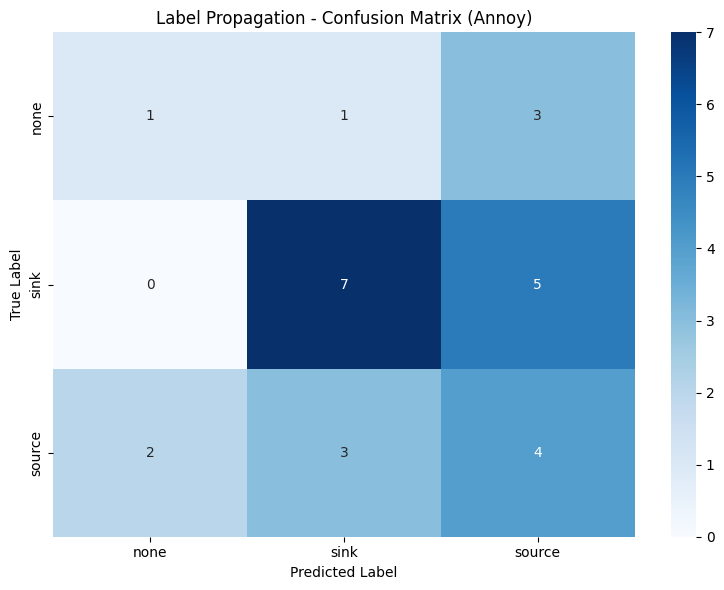

🎯 EVALUATION SUMMARY
📊 Total labeled methods: 85
🔍 Optimal k value: 5
📈 Total predictions made: 0
📊 Overall accuracy: 0.462
📊 Macro F1-score: 0.413
📊 Weighted F1-score: 0.461

📋 Per-class performance:
    none: P=0.333, R=0.200, F1=0.250, Support=5.0
    sink: P=0.636, R=0.583, F1=0.609, Support=12.0
  source: P=0.333, R=0.444, F1=0.381, Support=9.0


In [18]:
# Model Evaluation and Parameter Tuning
print("\n" + "="*50)
print("STEP 3: Model Evaluation and Parameter Tuning")
print("="*50)

# Find optimal k value
best_k = propagator.find_optimal_k([3, 5, 7, 10])

# Detailed evaluation with train/test split
if len(propagator.method_labels) >= 10:
    evaluation_results = propagator.evaluate_propagation(k=best_k)
    
    # Use visualization utility for evaluation summary
    print_evaluation_summary(
        evaluation_results, 
        best_k, 
        len(propagator.method_labels), 
        0  # Will be updated after predictions
    )
else:
    print("⚠️ Not enough labeled data for detailed evaluation")
    evaluation_results = {}

In [ ]:
print("\n" + "="*50)
print("STEP 4: Within-Service Label Propagation")
print("="*50)

# Test different similarity thresholds
thresholds = [0.5, 0.6, 0.7, 0.8]
results_by_threshold = {}

for threshold in thresholds:
    print(f"\n🔄 Testing similarity threshold: {threshold}")
    predictions = propagator.propagate_all_services(k=best_k, threshold=threshold, max_iterations=30, min_confidence=0.5, min_threshold=0.1)

    total_predictions = sum(len(pred) for pred in predictions.values())
    results_by_threshold[threshold] = {
        'predictions': predictions,
        'total_count': total_predictions
    }
    print(f"📊 Total predictions: {total_predictions}")
    
    # Use visualization utility for service predictions summary
    print_service_predictions_summary(predictions)



STEP 4: Within-Service Label Propagation

🔄 Testing similarity threshold: 0.5
🔄 Propagating in s3: 10 labeled → 103 unlabeled
🔄 Iteration 1: 103 remaining unlabeled (threshold: 0.5)
✅ Added 30 new predictions
🔄 Iteration 2: 73 remaining unlabeled (threshold: 0.5)
✅ Added 29 new predictions
🔄 Iteration 3: 44 remaining unlabeled (threshold: 0.5)
✅ Added 17 new predictions
🔄 Iteration 4: 27 remaining unlabeled (threshold: 0.5)
✅ Added 13 new predictions
🔄 Iteration 5: 14 remaining unlabeled (threshold: 0.5)
✅ Added 4 new predictions
🔄 Iteration 6: 10 remaining unlabeled (threshold: 0.5)
✅ Added 5 new predictions
🔄 Iteration 7: 5 remaining unlabeled (threshold: 0.5)
✅ Added 5 new predictions
🎉 All methods labeled after 8 iterations!
✅ s3: 103 predictions
🔄 Propagating in dynamodb: 11 labeled → 50 unlabeled
🔄 Iteration 1: 50 remaining unlabeled (threshold: 0.5)
✅ Added 35 new predictions
🔄 Iteration 2: 15 remaining unlabeled (threshold: 0.5)
✅ Added 15 new predictions
🎉 All methods labeled

In [ ]:
print("\n" + "="*50)
print("STEP 5: Threshold Analysis and Visualization")
print("="*50)

# Visualize threshold analysis
plot_threshold_analysis(results_by_threshold, "Threshold Impact on Predictions")

# Choose best threshold (you can adjust this based on analysis above)
chosen_threshold = 0.6  # Balance between quantity and quality
final_predictions = results_by_threshold[chosen_threshold]['predictions']

print(f"✅ Using threshold: {chosen_threshold}")
print(f"📊 Final within-service predictions: {sum(len(pred) for pred in final_predictions.values())}")

In [ ]:
print("\n" + "="*50)
print("STEP 6: Cross-Service Propagation Testing")
print("="*50)

# Get similar services suggestions
similar_services = propagator.get_similar_services()

print("🔀 Testing cross-service propagation for similar services:")

cross_service_predictions = {}
cross_service_tests = [
    ('s3', 'efs'),
    ('dynamodb', 'rds'), 
    ('sqs', 'eventbridge'),
    ('iam', 'sts')
]

for source_service, target_service in cross_service_tests:
    if (source_service in propagator.service_methods and 
        target_service in propagator.service_methods):
        
        print(f"\n🔀 Testing: {source_service} → {target_service}")
        cross_pred = propagator.propagate_cross_service(
            source_service, target_service, k=best_k, threshold=0.5
        )
        
        if cross_pred:
            cross_service_predictions[f"{source_service}_to_{target_service}"] = cross_pred
            
            # Use visualization utility for cross-service summary
            print_service_predictions_summary({f"{source_service}_to_{target_service}": cross_pred})
        else:
            print(f"❌ No predictions made (low similarity or no data)")


In [ ]:
print("\n" + "="*50)
print("STEP 7: Comprehensive Visualization Dashboard")
print("="*50)

# Create comprehensive visualization dashboard
create_results_dashboard(
    final_predictions,
    evaluation_results,
    results_by_threshold
)


In [ ]:
print("\n" + "="*50)
print("STEP 8: Saving Results")
print("="*50)

# Save within-service predictions
within_service_file = project_root / "within_service_predictions.json"
within_service_metadata = {
    'type': 'within_service_propagation',
    'embedding_format': propagator.embedding_format,
    'k_neighbors': best_k,
    'similarity_threshold': chosen_threshold,
    'labeled_services': labeled_services,
    'total_labeled_methods': len(propagator.method_labels),
    'total_predictions': sum(len(pred) for pred in final_predictions.values())
}

propagator.save_predictions(final_predictions, within_service_file, within_service_metadata)

# Save cross-service predictions if any
if cross_service_predictions:
    cross_service_file = project_root / "cross_service_predictions.json"
    cross_service_metadata = {
        'type': 'cross_service_propagation',
        'embedding_format': propagator.embedding_format,
        'k_neighbors': best_k,
        'similarity_threshold': 0.5,  # Used for cross-service
        'total_predictions': sum(len(pred) for pred in cross_service_predictions.values())
    }
    
    propagator.save_predictions(cross_service_predictions, cross_service_file, cross_service_metadata)

# Save visualization summary
viz_summary_file = project_root / "visualization_summary.json"
save_visualization_summary(final_predictions, viz_summary_file, within_service_metadata)

# Generate comprehensive summary
summary = {
    'experiment_metadata': {
        'embedding_format': propagator.embedding_format,
        'optimal_k': best_k,
        'within_service_threshold': chosen_threshold,
        'cross_service_threshold': 0.5,
        'labeled_services': labeled_services,
        'total_labeled_methods': len(propagator.method_labels),
        'evaluation_results': evaluation_results
    },
    'within_service_results': {
        'total_predictions': sum(len(pred) for pred in final_predictions.values()),
        'predictions_by_service': {}
    },
    'cross_service_results': {
        'total_predictions': sum(len(pred) for pred in cross_service_predictions.values()),
        'successful_transfers': list(cross_service_predictions.keys())
    },
    'recommendations': {
        'high_confidence_services': [],
        'manual_review_needed': [],
        'next_similar_services': {}
    }
}

# Analyze within-service results for recommendations
for service, predictions in final_predictions.items():
    service_summary = {
        'total_predictions': len(predictions),
        'label_distribution': {},
        'avg_confidence': 0,
        'high_confidence_count': 0
    }
    
    total_conf = 0
    for method, pred_data in predictions.items():
        label = pred_data['label']
        confidence = pred_data['confidence']
        
        service_summary['label_distribution'][label] = service_summary['label_distribution'].get(label, 0) + 1
        total_conf += confidence
        
        if confidence > 0.8:
            service_summary['high_confidence_count'] += 1
    
    if len(predictions) > 0:
        service_summary['avg_confidence'] = total_conf / len(predictions)
        
        # Add to recommendations
        if service_summary['avg_confidence'] > 0.7 and len(predictions) >= 5:
            summary['recommendations']['high_confidence_services'].append(service)
        
        low_conf_count = len(predictions) - service_summary['high_confidence_count']
        if low_conf_count > len(predictions) * 0.3:  # More than 30% low confidence
            summary['recommendations']['manual_review_needed'].append(service)
    
    summary['within_service_results']['predictions_by_service'][service] = service_summary

# Add similar services recommendations
for service in labeled_services:
    if service.lower() in similar_services:
        summary['recommendations']['next_similar_services'][service] = similar_services[service.lower()]

# Save summary
summary_file = project_root / "propagation_summary.json"
with open(summary_file, 'w') as f:
    json.dump(summary, f, indent=2)

print(f"💾 Summary saved to: {summary_file}")

# Save Annoy indexes after building
print("\n💾 Saving Annoy indexes...")
propagator.save_indexes(annoy_indexes_dir)

In [ ]:
print("\n" + "="*50)
print("FINAL RESULTS AND RECOMMENDATIONS")
print("="*50)

# Use visualization utility for final summary
print_evaluation_summary(
    evaluation_results, 
    best_k, 
    len(propagator.method_labels), 
    sum(len(pred) for pred in final_predictions.values())
)

print(f"🎉 Label propagation complete!")
print(f"📊 Within-service predictions: {sum(len(pred) for pred in final_predictions.values())}")
if cross_service_predictions:
    print(f"🔀 Cross-service predictions: {sum(len(pred) for pred in cross_service_predictions.values())}")

print("🎯 Next Steps Recommendations:")

print("1. ✅ High-confidence services (ready for use):")
for service in summary['recommendations']['high_confidence_services']:
    pred_count = len(final_predictions.get(service, {}))
    avg_conf = summary['within_service_results']['predictions_by_service'][service]['avg_confidence']
    print(f"   • {service}: {pred_count} predictions, {avg_conf:.3f} avg confidence")

print("2. ⚠️  Services needing manual review:")
for service in summary['recommendations']['manual_review_needed']:
    pred_count = len(final_predictions.get(service, {}))
    print(f"   • {service}: {pred_count} predictions (review low-confidence ones)")

print("3. 🔀 Recommended similar services for cross-service propagation:")
for source_service, similar_list in summary['recommendations']['next_similar_services'].items():
    if similar_list:
        print(f"   • {source_service} → {', '.join(similar_list)}")

print("4. 📁 Files generated:")
print(f"   • {within_service_file.name} - Within-service predictions")
if cross_service_predictions:
    print(f"   • {cross_service_file.name} - Cross-service predictions")
print(f"   • {summary_file.name} - Complete analysis summary")
print(f"   • {viz_summary_file.name} - Visualization data summary")
print(f"   • {annoy_indexes_dir.name}/ - Annoy indexes for fast similarity search")

print(f"🎊 Process complete! Review the generated files and high-confidence predictions.")